In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from src.utils.general import get_db_conn, get_boto3_session, load_model_s3, load_matrix_s3
from src.utils import project_constants as constants

In [4]:
cred_file = '../conf/local/credentials.yaml'
db_conn=get_db_conn(cred_file)
s3_session = get_boto3_session(cred_file)

In [5]:
experiment_hash = '102f4996db3d114aa68dda958d1446cc'
model_group = 376
# project_folder='s3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_long_term_master'

#### Models

In [6]:
q = """
    select 
        model_id
    from triage_metadata.models
    where model_group_id={model_group}
    and built_by_experiment='{experiment_hash}'
""".format(
    model_group=model_group,
    experiment_hash=experiment_hash
)

models_ids = pd.read_sql(q, db_conn)['model_id'].tolist()

In [7]:
models_ids

[7714, 7741, 7768, 7795, 7822, 7849, 7876, 7903, 7930, 7957, 7984, 8011, 8038]

In [8]:
score_buckets = """
    with predictions as (
        select 
            a.*, b.train_end_time
        from test_results.predictions a join triage_metadata.models b using(model_id)
        where model_id = {model_id}
        order by score desc
    )
    select 
        max(model_id) as model_id,
        max(train_end_time) as train_end_time,
        width_bucket(score, 0, 1, 10) as score_buckets,
        (sum(label_value)::float/count(*)) * 100 as passage_probability,
        round(min(score), 2) as bucket_lower_bound,
        count(*) as num_records_in_bucket,
        sum(label_value) as num_ones_in_bucket
    from predictions
    group by score_buckets
    order by score_buckets
"""

In [9]:
prediction_prob_score_range = pd.DataFrame()

for mod_id in models_ids:
#     print(mod_id)
    q = score_buckets.format(model_id=mod_id)
    temp = pd.read_sql(q, db_conn)
    tot_recs = temp['num_records_in_bucket'].sum()
    tot_ones = temp['num_ones_in_bucket'].sum()
    
    temp['frac_records_in_bucket'] = temp['num_records_in_bucket']/tot_recs
    temp['frac_ones_in_bucket'] = temp['num_ones_in_bucket']/tot_ones
    temp['base_prevelance'] = (float(tot_ones) /tot_recs) * 100
    temp['tot_ones'] = tot_ones
    temp['tot_instances'] = tot_recs
    
    prediction_prob_score_range = prediction_prob_score_range.append(temp, ignore_index=True)
    

#### Single model

In [10]:
model_id = 7768

In [11]:
q = """select * from test_results.predictions where model_id={}""".format(model_id)
model_scores = pd.read_sql(q, db_conn)

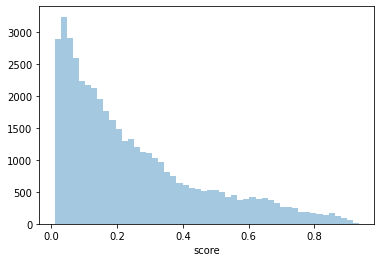

In [14]:
# model_scores['score'].hist(bins=100)
sns.distplot(model_scores['score'], kde=False)

Text(0.5, 1.0, 'Passage probability for score buckets -- Model id 7768')

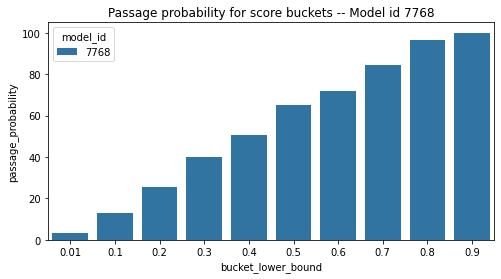

In [84]:
fig, ax = plt.subplots(figsize=(8, 4))
msk = (prediction_prob_score_range['model_id'] == model_id)
sns.barplot(data=prediction_prob_score_range[msk], x='bucket_lower_bound', y='passage_probability', hue='model_id')
ax.set_title('Passage probability for score buckets -- Model id {}'.format(model_id))

#### all models in group

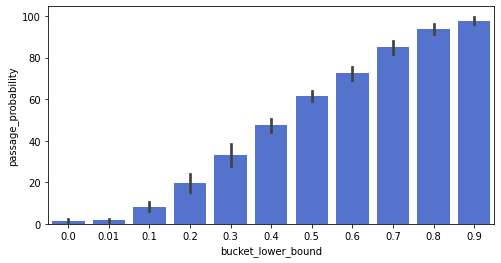

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(
    data=prediction_prob_score_range, 
    x='bucket_lower_bound', y='passage_probability', ci='sd', color='royalblue')

#### Threshold over time

Text(0.5, 1.0, 'Passage probability dist. over time at score threshold -- 0.9')

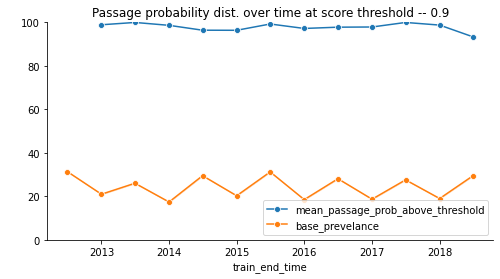

In [20]:
score_threshold = 0.9

fig, ax = plt.subplots(figsize=(8, 4))
msk = (prediction_prob_score_range['bucket_lower_bound'] >= score_threshold)
sns.lineplot(
    data=prediction_prob_score_range[msk], 
    x='train_end_time', y='passage_probability', estimator='mean', ci='sd', marker='o', 
    label='mean_passage_prob_above_threshold'
)
sns.lineplot(
    data=prediction_prob_score_range, 
    x='train_end_time', y='base_prevelance', estimator='mean', ci='sd', marker='o', 
    label='base_prevelance')

sns.despine()
ax.set_ylim(0, 100)
ax.set_ylabel(' ')
ax.set_title('Passage probability dist. over time at score threshold -- {}'.format(score_threshold))

Text(0.5, 1.0, 'Fraction of instances & frac of positive instances over time at score threshold 0.7')

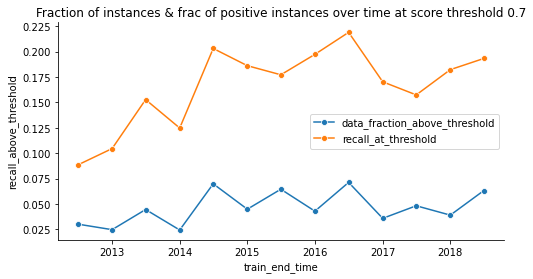

In [76]:
score_threshold = 0.7

fig, ax = plt.subplots(figsize=(8, 4))
msk = (prediction_prob_score_range['bucket_lower_bound'] >= score_threshold)
t = prediction_prob_score_range[msk].groupby('train_end_time', as_index=False).sum()[['train_end_time','num_records_in_bucket', 'num_ones_in_bucket']]
t2 = prediction_prob_score_range[msk].groupby('train_end_time', as_index=False).mean()[['train_end_time','tot_instances', 'tot_ones']]

t = t.merge(t2, on='train_end_time', suffixes=('_above_threshold', '_all'))
t['data_fraction_above_threshold'] = t['num_records_in_bucket'] / t['tot_instances']
t['recall_above_threshold'] = t['num_ones_in_bucket'] / t['tot_ones']

sns.lineplot(
    data=t, 
    x='train_end_time', y='data_fraction_above_threshold', estimator='mean', ci='sd', 
    marker='o', label='data_fraction_above_threshold'
)
sns.lineplot(
    data=t, 
    x='train_end_time', y='recall_above_threshold', estimator='mean', ci='sd', 
    marker='o', label='recall_at_threshold'
)


sns.despine()
# ax.set_ylim(0, 0.50)
ax.set_title('Fraction of instances & frac of positive instances over time at score threshold {}'.format(score_threshold))


In [70]:
# msk2 = prediction_prob_score_range['model_id'] == 7714
t = prediction_prob_score_range[msk].groupby('train_end_time', as_index=False).sum()[['train_end_time','num_records_in_bucket', 'num_ones_in_bucket']]
t2 = prediction_prob_score_range[msk].groupby('train_end_time', as_index=False).mean()[['train_end_time','tot_instances', 'tot_ones']]

t = t.merge(t2, on='train_end_time', suffixes=('_above_threshold', '_all'))
t['data_fraction_above_threshold'] = t['num_records_in_bucket'] / t['tot_instances']
t['recall_above_threshold'] = t['num_ones_in_bucket'] / t['tot_ones']

## Overall

In [98]:
q = """
    with predictions as (
        select 
            *
        from test_results.predictions 
        where model_id in {}
        order by score desc
    )
    select 
        width_bucket(score, 0, 1, 10) as score_buckets,
        (sum(label_value)::float/count(*)) * 100 as passage_probability,
        round(min(score), 2) as bucket_lower_bound
    from predictions
    group by score_buckets
    order by score_buckets
""".format(tuple(models_ids))

overall_score_buckets = pd.read_sql(q, db_conn)


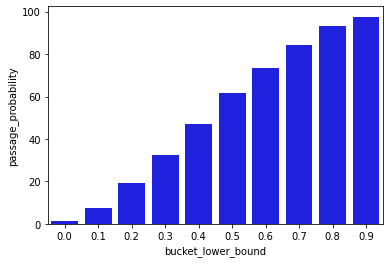

In [78]:
sns.barplot(data=overall_score_buckets, x='bucket_lower_bound', y='passage_probability', color='blue')

#### Deciles

In [22]:
score_perc = """
    with predictions as (
        select 
            a.*, b.train_end_time
        from test_results.predictions a join triage_metadata.models b using(model_id)
        where model_id={model_id}
        order by score desc
    ),
    buckets as (
        select 
            predictions.*,
            case 
                when score > d90 then 90
                when (score > d80) and (score <= d90) then 80
                when (score > d70) and (score <= d80) then 70
                when (score > d60) and (score <= d70) then 60
                when (score > d50) and (score <= d60) then 50
                when (score > d40) and (score <= d50) then 40
                when (score > d30) and (score <= d40) then 30
                when (score > d20) and (score <= d30) then 20
                when (score > d10) and (score <= d20) then 10
                else 0
            end as decile_lower_bound
        from (
            select 
                percentile_cont(0.90) within group (order by score) as d90,
                percentile_cont(0.80) within group (order by score) as d80,
                percentile_cont(0.70) within group (order by score) as d70,
                percentile_cont(0.60) within group (order by score) as d60,
                percentile_cont(0.50) within group (order by score) as d50,
                percentile_cont(0.40) within group (order by score) as d40,
                percentile_cont(0.30) within group (order by score) as d30,
                percentile_cont(0.20) within group (order by score) as d20,
                percentile_cont(0.10) within group (order by score) as d10
            from predictions
        ) as t, predictions
    )
    select 
        max(model_id) as model_id,
        max(train_end_time) as train_end_time,
        decile_lower_bound,
        count(*) as num_records_in_bucket,
        sum(label_value) as num_ones_in_bucket,
        (sum(label_value)::float/count(*)) * 100 as passage_probability
    from buckets
    group by decile_lower_bound
    order by decile_lower_bound
"""

In [23]:
prediction_prob_deciles = pd.DataFrame()

for mod_id in models_ids:
    q = score_perc.format(model_id=mod_id)
    temp = pd.read_sql(q, db_conn)
#     tot_recs = temp['num_records'].sum()
#     tot_ones = temp['num_ones'].sum()
#     temp['frac_records'] = temp['num_records']/tot_recs
#     temp['frac_ones'] = temp['num_ones']/tot_ones
#     temp['base_passage_prob'] = (float(tot_ones) /tot_recs) * 100
    
    tot_recs = temp['num_records_in_bucket'].sum()
    tot_ones = temp['num_ones_in_bucket'].sum()
    
    temp['frac_records_in_bucket'] = temp['num_records_in_bucket']/tot_recs
    temp['frac_ones_in_bucket'] = temp['num_ones_in_bucket']/tot_ones
    temp['base_prevelance'] = (float(tot_ones) /tot_recs) * 100
    temp['tot_ones'] = tot_ones
    temp['tot_instances'] = tot_recs
    
    
    prediction_prob_deciles = prediction_prob_deciles.append(temp, ignore_index=True)

#### Overall

Text(0.5, 1.0, 'Passage probability -- Score decile overall')

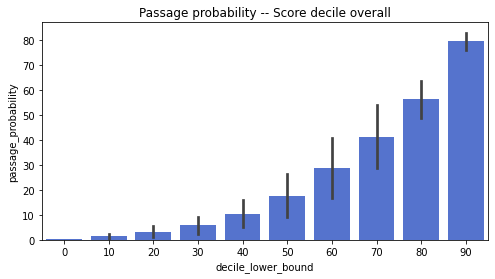

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=prediction_prob_deciles, x='decile_lower_bound', y='passage_probability', ci='sd', color='royalblue')
ax.set_title('Passage probability -- Score decile overall')

Text(0.5, 1.0, 'Passage probability -- Score decile Model id 7768')

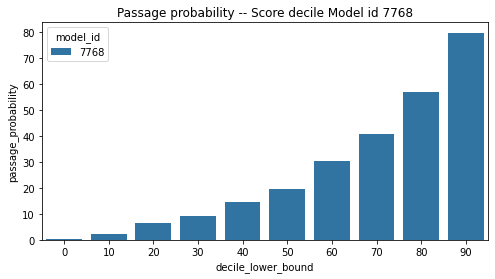

In [106]:
fig, ax = plt.subplots(figsize=(8, 4))
msk = (prediction_prob_deciles['model_id'] == model_id)
sns.barplot(data=prediction_prob_deciles[msk], x='decile_lower_bound', y='passage_probability', hue='model_id')
ax.set_title('Passage probability -- Score decile Model id {}'.format(model_id))

Text(0.5, 1.0, 'Fraction of instances & frac of positive instances over time above score decile 80')

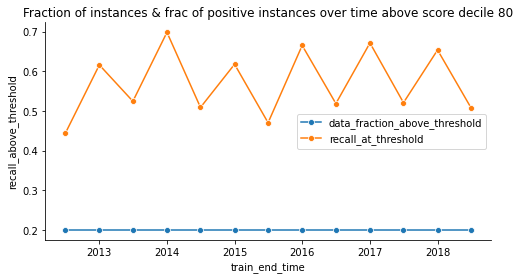

In [112]:
score_threshold = 80

fig, ax = plt.subplots(figsize=(8, 4))
msk = (prediction_prob_deciles['decile_lower_bound'] >= score_threshold)
t = prediction_prob_deciles[msk].groupby('train_end_time', as_index=False).sum()[['train_end_time','num_records_in_bucket', 'num_ones_in_bucket']]
t2 = prediction_prob_deciles[msk].groupby('train_end_time', as_index=False).mean()[['train_end_time','tot_instances', 'tot_ones']]

t = t.merge(t2, on='train_end_time', suffixes=('_above_threshold', '_all'))
t['data_fraction_above_threshold'] = t['num_records_in_bucket'] / t['tot_instances']
t['recall_above_threshold'] = t['num_ones_in_bucket'] / t['tot_ones']

sns.lineplot(
    data=t, 
    x='train_end_time', y='data_fraction_above_threshold', estimator='mean', ci='sd', 
    marker='o', label='data_fraction_above_threshold'
)
sns.lineplot(
    data=t, 
    x='train_end_time', y='recall_above_threshold', estimator='mean', ci='sd', 
    marker='o', label='recall_at_threshold'
)


sns.despine()
# ax.set_ylim(0, 0.50)
ax.set_title('Fraction of instances & frac of positive instances over time above score decile {}'.format(score_threshold))


In [110]:
prediction_prob_deciles.head()

,model_id,train_end_time,decile_lower_bound,num_records_in_bucket,num_ones_in_bucket,passage_probability,frac_records_in_bucket,frac_ones_in_bucket,base_prevelance,tot_ones,tot_instances
0,7714,2012-07-01,0,5916,20,0.338066,0.100010,0.001077,31.402779,18576,59154
1,7714,2012-07-01,10,5916,173,2.924273,0.100010,0.009313,31.402779,18576,59154
2,7714,2012-07-01,20,5916,403,6.812035,0.100010,0.021695,31.402779,18576,59154
3,7714,2012-07-01,30,5915,767,12.967033,0.099993,0.041290,31.402779,18576,59154
4,7714,2012-07-01,40,5914,1406,23.774095,0.099976,0.075689,31.402779,18576,59154
